In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid#
import torchvision
import os
import random
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
def build_datasets():

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    trainset = torchvision.datasets.ImageFolder(root='BreakHis/BreakHis/Train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
    validset = torchvision.datasets.ImageFolder(root='Breast_cancer_40A/valid', transform=transform)
    validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                         shuffle=False, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='Breast_cancer_40A/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

    return trainloader,validloader, testloader

classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

In [6]:
trainloader,validloader, testloader = build_datasets()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


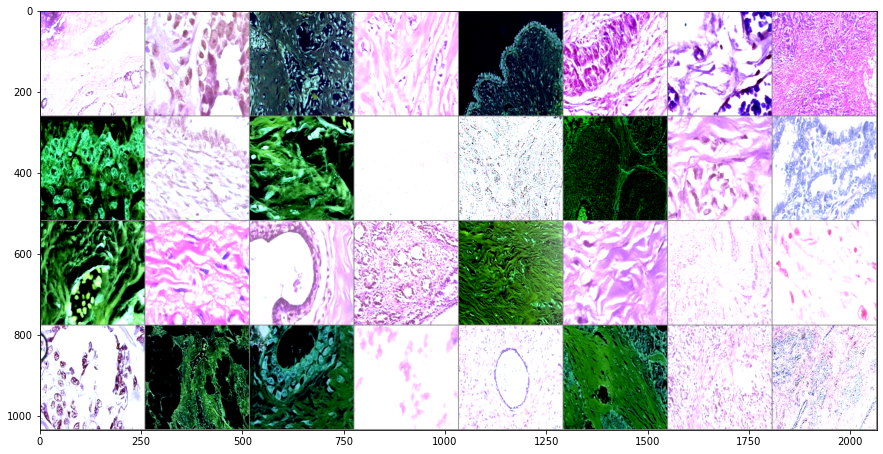

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [15]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, num_classes: int = 8, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.MaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = CNN()
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 256, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fe

In [4]:
import torch
print(torch.__version__)

import torch
print(torch.__version__)

1.10.0
1.10.0


In [16]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def valid(model,iterator):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import time

train_l = []
train_a = []
valid_l = []
valid_a = []

if __name__ == '__main__':

    for epoch in range(30):
        start_time = time.monotonic()
        train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_acc = valid(net, validloader)
        
        train_l.append(train_loss)
        train_a.append(train_acc)
        valid_l.append(valid_loss)
        valid_a.append(valid_acc)
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network test images: %d %%' % (
            100 * correct / total))

Epoch: 01 | Epoch Time: 3m 28s
	Train Loss: 1.999 | Train Acc: 18.30%
	Valid Loss: 2.016 | Valid Acc: 20.49%
Epoch: 02 | Epoch Time: 3m 26s
	Train Loss: 1.811 | Train Acc: 28.75%
	Valid Loss: 1.720 | Valid Acc: 32.99%
Epoch: 03 | Epoch Time: 3m 26s
	Train Loss: 1.621 | Train Acc: 36.41%
	Valid Loss: 1.710 | Valid Acc: 32.41%
Epoch: 04 | Epoch Time: 3m 26s
	Train Loss: 1.590 | Train Acc: 37.30%
	Valid Loss: 1.674 | Valid Acc: 33.72%
Epoch: 05 | Epoch Time: 3m 28s
	Train Loss: 1.548 | Train Acc: 38.34%
	Valid Loss: 1.848 | Valid Acc: 34.16%
Epoch: 06 | Epoch Time: 3m 28s
	Train Loss: 1.512 | Train Acc: 39.36%
	Valid Loss: 1.731 | Valid Acc: 38.37%
Epoch: 07 | Epoch Time: 3m 27s
	Train Loss: 1.435 | Train Acc: 41.73%
	Valid Loss: 1.688 | Valid Acc: 45.06%
Epoch: 08 | Epoch Time: 3m 31s
	Train Loss: 1.308 | Train Acc: 48.13%
	Valid Loss: 1.382 | Valid Acc: 50.87%
Epoch: 09 | Epoch Time: 3m 26s
	Train Loss: 1.185 | Train Acc: 54.38%
	Valid Loss: 1.250 | Valid Acc: 60.90%
Epoch: 10 | Epoch T

In [21]:
print(train_a)

[0.18303273215083654, 0.2874916499865079, 0.364061456255779, 0.37299599198396793, 0.383433533754043, 0.39362057452211396, 0.41733466933867736, 0.4812959252235168, 0.5438376753507014, 0.639696058744419, 0.7277889111954606, 0.8063627254509018, 0.8607214428857716, 0.9039746158586476, 0.9207581829929161, 0.921259184996924, 0.938877755511022, 0.9604208416833667, 0.9468102872013329, 0.9619238476953907, 0.970691382765531, 0.9579158316633266, 0.9599198396793587, 0.9570808282834973, 0.968687374749499, 0.9711923847695391, 0.9836339344959221, 0.9809619238476954, 0.9744488977955912, 0.9857214428857716]


In [14]:
classes = ('Adenosis', 'Fibroadenoma', 'Phyllodes_tumor' ,'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Adenosis is: 96.5 %
Accuracy for class Fibroadenoma is: 88.4 %
Accuracy for class Phyllodes_tumor is: 90.7 %
Accuracy for class Tubular_adenoma is: 73.3 %
Accuracy for class Ductal_Carcinoma is: 82.6 %
Accuracy for class Lobular_Carcinoma is: 81.4 %
Accuracy for class Mucinous_Carcinoma is: 95.3 %
Accuracy for class Papillary_Carcinoma is: 90.7 %


In [15]:
import sklearn

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('Confusion matrix:')
print(sklearn.metrics.confusion_matrix(actuals, predictions))
print('F1 score: %f' % sklearn.metrics.f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % sklearn.metrics.accuracy_score(actuals, predictions))

Confusion matrix:
[[83  0  2  0  1  0  0  0]
 [ 0 76  1  0  7  0  0  2]
 [ 0  4 78  0  0  0  4  0]
 [ 0 14  2 63  5  0  2  0]
 [ 3  5  0  0 71  3  1  3]
 [ 1  3  3  0  7 70  2  0]
 [ 0  0  2  0  1  0 82  1]
 [ 0  0  4  0  1  1  2 78]]
F1 score: 0.873547
Accuracy score: 0.873547


In [18]:
a = [[83/86,  0,  2/86,  0 , 1/86  ,0 , 0 , 0],
     [ 0 ,76/87 , 1/87 , 0 , 7/87,  0 , 0,  2/87],
     [ 0 , 4/86, 78/86 , 0 , 0 , 0,  4/86 , 0],
     [ 0, 14/86 , 2/86 ,63/86,  5/86,  0 , 2/86,  0],
     [ 3/86 , 5/86 , 0 , 0, 71/86 , 3/86 , 1/86 , 3/86],
     [ 1/86  ,3/86,  3/86, 0/86,  7/86, 70/86 , 2/86  ,0],
     [ 0,  0,  2/86 , 0,  1/86 , 0 ,82/86,  1/86],
     [ 0 , 0 , 4/86  ,0 , 1/86,  1/86 , 2/86 ,78/86]]

<AxesSubplot:>

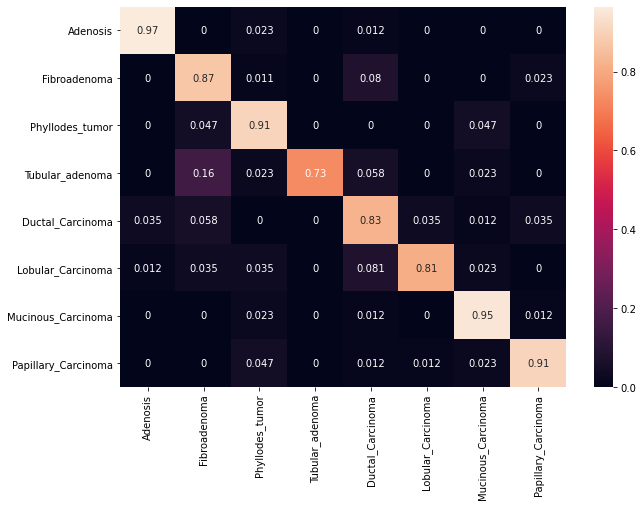

In [19]:
classes = ('Adenosis', 'Fibroadenoma','Phyllodes_tumor', 'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma')

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = a
df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [1]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 0
actuals, class_probabilities = test_class_probabilities(net, device, testloader, which_class)

fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, class_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label= %d ' % which_class)
plt.legend(loc="lower right")
plt.show()

NameError: name 'net' is not defined

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


/Users/zakariaemkassi/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:80: UserWarning: Label not 3 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/Users/zakariaemkassi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


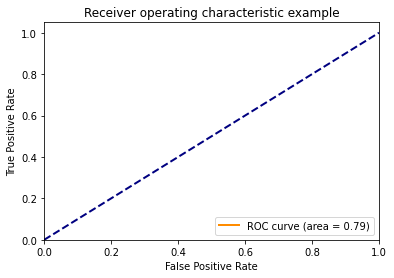

In [16]:
plt.figure()
lw = 2
plt.plot(
    fpr[3],
    tpr[3],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()